In [32]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rasterio
from skimage import io
import cv2
import scipy.io
from utils import *
from skimage.transform import resize

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
houston_tain_tif='./dataset/houston/TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif'
houston_rgb_tif='./dataset/houston/Final RGB HR Imagery/UH_NAD83_271460_3289689.tif'
houston_pix='./dataset/houston/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix'
houston_hdr='./dataset/houston/FullHSIDataset/20170218_UH_CASI_S4_NAD83.hdr'
houstom_mat='./dataset/houston/FullHSIDataset/20170218_UH_CASI_S4_NAD83.mat'
houston_normalied_mat='./dataset/houston/FullHSIDataset/20170218_UH_CASI_S4_NAD83_normalized.mat'

In [ ]:
def convert_pix_to_mat(file_path):
    """
    Reads a .pix file and saves it as a .mat file in the same directory with the same name.

    Parameters:
    - file_path: str, path to the input .pix file.
    """
    # Read the .pix file
    with rasterio.open(file_path) as dataset:
        pix_data = dataset.read()
    
    # Get the directory and file name without extension
    dir_name = os.path.dirname(file_path)
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    
    # Create the output .mat file path
    mat_file_path = os.path.join(dir_name, f"{base_name}.mat")
    
    # Save the .pix data to a .mat file
    scipy.io.savemat(mat_file_path, {'image': pix_data})
    
    print(f".pix data saved to {mat_file_path}")

convert_pix_to_mat(houston_pix)

In [ ]:
def normalize_mat_image(mat_file_path, key):
    """
    Normalizes the values in a .mat image to the range [0, 1] and saves the normalized image.

    Parameters:
    - mat_file_path: str, path to the .mat file.
    - key: str, key of the image data in the .mat file.

    Returns:
    - normalized_image: np.ndarray, the normalized image.
    """
    # Load the .mat file
    data = scipy.io.loadmat(mat_file_path)
    
    # Extract the image data using the provided key
    image = data[key]
    
    # Normalize the image to the range [0, 1]
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = (image - min_val) / (max_val - min_val)
    
    # Save the normalized image to a new .mat file
    dir_name = os.path.dirname(mat_file_path)
    base_name = os.path.splitext(os.path.basename(mat_file_path))[0]
    normalized_mat_file_path = os.path.join(dir_name, f"{base_name}_normalized.mat")
    scipy.io.savemat(normalized_mat_file_path, {key: normalized_image})
    
    print(f"Normalized image saved to {normalized_mat_file_path}")
    
    return normalized_image

# Example usage
normalized_image = normalize_mat_image(houstom_mat, 'image')  
print(normalized_image)

In [7]:
def plot_geotiff(file_path, band_index=50):
    """
    Plots the specified band of a GeoTIFF file.
    
    Parameters:
    - file_path: str, path to the GeoTIFF file.
    - band_index: int, index of the band to plot (default is 50).
    """
    # Open the GeoTIFF file
    with rasterio.open(file_path) as src:
        # Read the specified band
        band = src.read(band_index)
        
        # Plot the band
        plt.imshow(band, cmap='Spectral')
        plt.title(f'{os.path.basename(file_path)} Band {band_index}')
        plt.axis('off')
        plt.show()
    # Plot the metadata
    metadata = src.meta
    # print("GeoTIFF Metadata:")
    # for key, value in metadata.items():
        # print(f"{key}: {value}")


In [19]:
def print_geotiff_info(file_path):
    # Open the GeoTIFF file
    print("--------------------")
    print(f"FILE: {os.path.basename(file_path)}")
    
    with rasterio.open(file_path) as dataset:
        img=dataset.read()
        # print(f"Metadata: {dataset.meta}")
        print(f"raster shape:   {img.shape}")
        # print(f"raster Shape: {dataset.shape}")
        # print(f"raster width: {dataset.width}")
        # print(f"raster height: {dataset.height}")
        # print(f"raster count: {dataset.count}")
    
    # dataset = gdal.Open(file_path)
    # array = dataset.ReadAsArray()
    # print(f"gdal shape:     {array.shape}")
    
    # ioimage = io.imread(file_path, plugin='tifffile')
    # print(f"skimage shape:  {ioimage.shape}") 

In [12]:
def plot_mat_info(mat_file_path):
    """
    Plots all the keys and the shape of all the images for each key in a .mat file.

    Parameters:
    - mat_file_path: str, path to the .mat file.
    """
    # Load the .mat file
    data = scipy.io.loadmat(mat_file_path)
    
    # Iterate over all keys in the .mat file
    for key in data:
        if isinstance(data[key], np.ndarray):
            array = data[key]
            print(f"Key: {key}, Shape: {array.shape}")
            
            # Plot the image if it is 2D or 3D
            if array.ndim == 2:
                plt.imshow(array, cmap='gray')
                plt.title(f'{key} (2D)')
                plt.axis('off')
                plt.show()
                
                # Plot histogram of the values
                plt.hist(array.ravel(), bins=256, color='gray', alpha=0.75)
                plt.title(f'{key} (2D) Value Distribution')
                plt.xlabel('Pixel Value')
                plt.ylabel('Frequency')
                plt.show()
                
            elif array.ndim == 3:
                # Plot the first three channels as an RGB image if possible
                if array.shape[0] >= 3:
                    rgb_image = np.stack((array[0, :, :], array[1, :, :], array[2, :, :]), axis=-1)
                    plt.imshow(rgb_image)
                    plt.title(f'{key} (3D)')
                    plt.axis('off')
                    plt.show()
                    
                    # Plot histogram of the values for each channel
                    for i in range(3):
                        plt.hist(array[i, :, :].ravel(), bins=256, alpha=0.75, label=f'Channel {i}')
                    plt.title(f'{key} (3D) Value Distribution')
                    plt.xlabel('Pixel Value')
                    plt.ylabel('Frequency')
                    plt.legend()
                    plt.show()
                else:
                    for i in range(array.shape[0]):
                        plt.imshow(array[i, :, :], cmap='gray')
                        plt.title(f'{key} (Channel {i})')
                        plt.axis('off')
                        plt.show()
                        
                        # Plot histogram of the values for each channel
                        plt.hist(array[i, :, :].ravel(), bins=256, color='gray', alpha=0.75)
                        plt.title(f'{key} (Channel {i}) Value Distribution')
                        plt.xlabel('Pixel Value')
                        plt.ylabel('Frequency')
                        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..9886].


Key: image, Shape: (50, 1202, 4172)


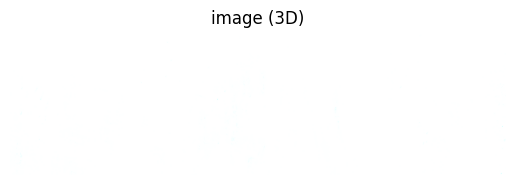

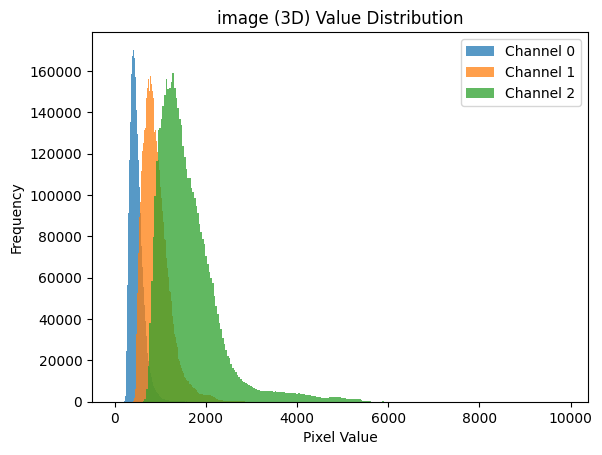

Key: image, Shape: (50, 1202, 4172)


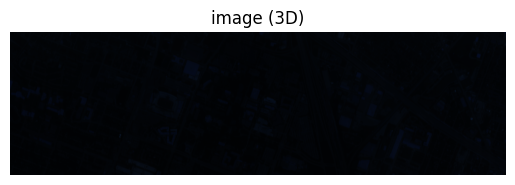

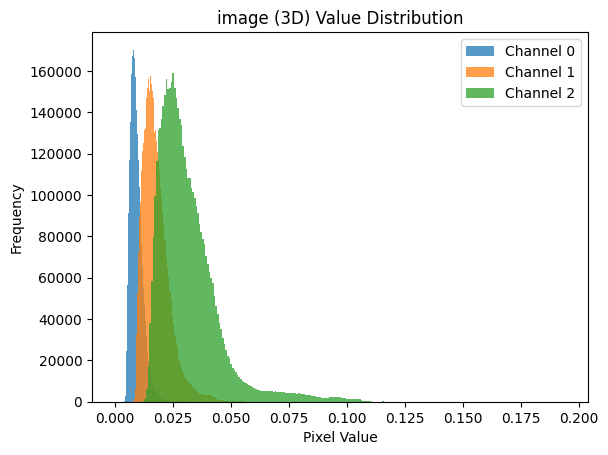

In [16]:
plot_mat_info(houstom_mat)
plot_mat_info(houston_normalied_mat)

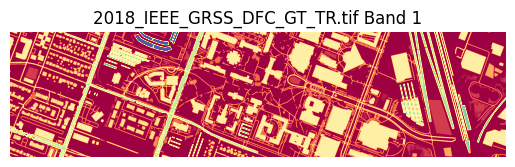

--------------------
FILE: 2018_IEEE_GRSS_DFC_GT_TR.tif
raster shape:   (1, 1202, 4768)


In [20]:
plot_geotiff(houston_tain_tif,1)
print_geotiff_info(houston_tain_tif)

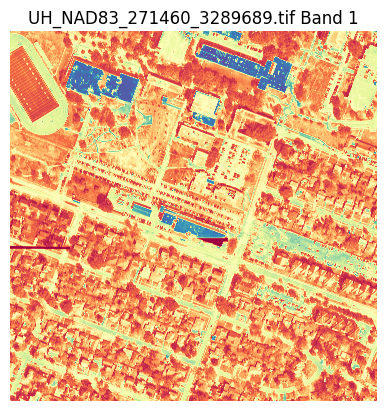

--------------------
FILE: UH_NAD83_271460_3289689.tif
raster shape:   (3, 12020, 11920)


In [22]:
plot_geotiff(houston_rgb_tif,1)
print_geotiff_info(houston_rgb_tif)

In [4]:
def transform_tif_to_mat(tif_path):
    """
    Transforms a GeoTIFF image to a .mat file with normalization using torch tensors.

    Parameters:
    - tif_path: str, path to the input GeoTIFF file.
    """
    # Read the GeoTIFF file
    with rasterio.open(tif_path) as src:
        image_data = src.read()
    
    # Convert to torch tensor and normalize
    image_tensor = torch.tensor(image_data, dtype=torch.float)

    # static normalization
    image_tensor = image_tensor / 36855
    mat_path = tif_path.replace('.tif', '_simple.mat')

    # # Simple Normalizer
    # image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())
    # mat_path = tif_path.replace('.tif', '.mat')
    
    # # Normalizer using BandMinMaxQuantileStateful
    # normalizer = BandMinMaxQuantileStateful()
    # normalizer.fit([image_tensor])
    # image_tensor = normalizer.transform(image_tensor).cpu()
    # mat_path = tif_path.replace('.tif', '_Quantile.mat')
    
    # Prepare the data dictionary to save as .mat
    data_dict = {
        'data': image_tensor.numpy()  # Save to 'data' key
    }
    # Save the data dictionary as a .mat file
    scipy.io.savemat(mat_path, data_dict)
    print(f"Transformed {tif_path} to {mat_path}")

transform_tif_to_mat('./dataset/hypso/vb_a.tif')

Transformed ./dataset/hypso/vb_a.tif to ./dataset/hypso/vb_a_simple.mat


In [71]:
def plot_rgb_composite(path, keys, red_band=69, green_band=46, blue_band=26, output=False):
    # Load the .mat file
    data = scipy.io.loadmat(path)
    
    # Extract the 3D arrays using the provided keys
    rgb_images = []
    for key in keys:
        array = data[key]
        if output:
            red = array[:, :, red_band]
            green = array[:, :, green_band]
            blue = array[:, :, blue_band]
        else:
            red = array[red_band, :, :]
            green = array[green_band, :, :]
            blue = array[blue_band, :, :]
        rgb_image = np.stack((red, green, blue), axis=-1)
        rgb_images.append(rgb_image)
    
    # Plot the images side by side
    if len(rgb_images) == 1:
        plt.imshow(rgb_images[0])
        plt.title(f'{keys[0]}')
        plt.axis('off')
        plt.figtext(0.5, 0.01, f'Data shape: {data[keys[0]].shape}', ha='center', fontsize=12)
    else:
        fig, axes = plt.subplots(1, len(rgb_images), figsize=(15, 5))
        for ax, rgb_image, key in zip(axes, rgb_images, keys):
            ax.imshow(rgb_image)
            ax.set_title(f'{key}')
            ax.axis('off')
            ax.text(0.5, -0.1, f'Data shape: {data[key].shape}', ha='center', va='center', transform=ax.transAxes, fontsize=10)
    
    # Include the shape of 'gt' as a label
    if 'gt' in keys:
        gt_shape = data['gt'].shape
        plt.figtext(0.5, 0.01, f'Shape of gt: {gt_shape} | File: {os.path.basename(path)}', ha='center', fontsize=12)
    plt.show()

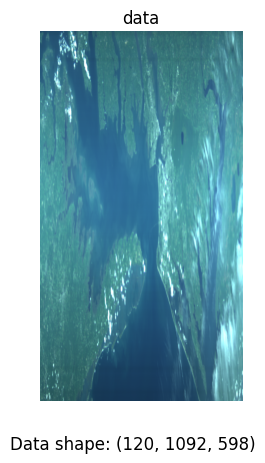

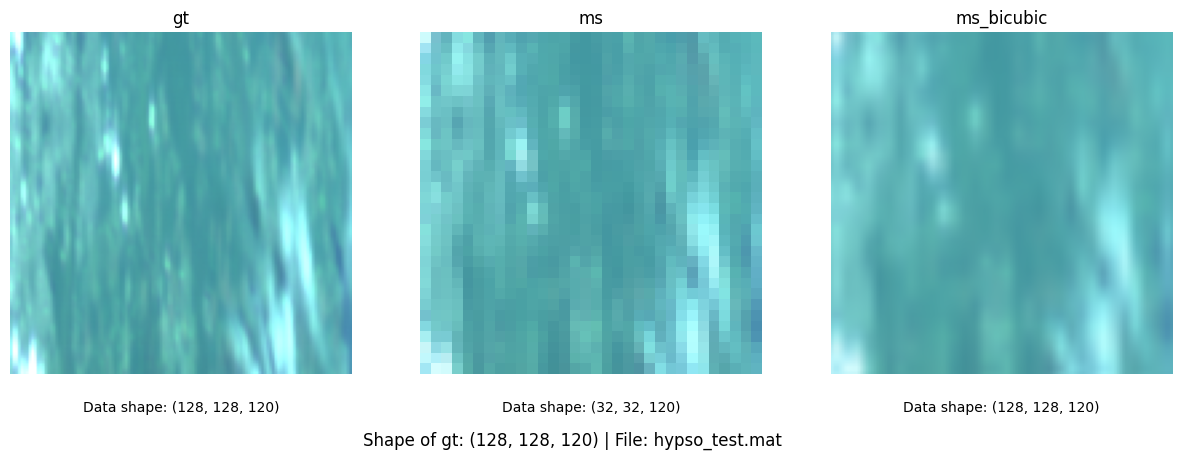

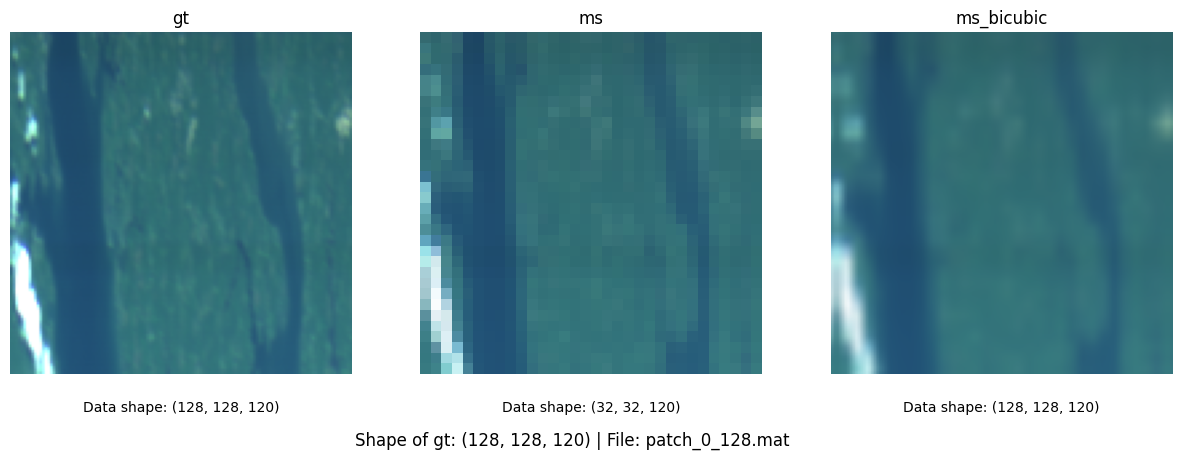

In [56]:
plot_rgb_composite('./dataset/hypso/vb_a_simple.mat', ['data'], output=False)
plot_rgb_composite('./dataset/hypso_x4/hypso_test.mat', ['gt', 'ms', 'ms_bicubic'], output=True)
plot_rgb_composite('./dataset/hypso_x4/trains/patch_0_128.mat', ['gt', 'ms', 'ms_bicubic'], output=True)


In [67]:
def visualize_model_output(npy_file, gt_file, rgb_bands=[69, 46, 26]):
    """
    Visualize and compare the model output with ground truth and input images.
    
    Args:
    npy_file (str): Path to the .npy file containing model output
    gt_file (str): Path to the .mat file containing ground truth and input images
    """
    def process_output(output):
        """Process the model output by averaging all output images."""
        return np.mean(output, axis=0)

    def visualize_hyperspectral(image, rgb_bands, title=""):
        """Visualize a hyperspectral image using three bands for RGB display."""
        rgb = image[:, :, rgb_bands]
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
        plt.imshow(rgb)
        plt.title(f"{title}\nShape: {image.shape}")
        plt.axis('off')

    # Load and process data
    data = np.load(npy_file)
    processed_image = process_output(data)
    mat_data = sio.loadmat(gt_file)
    gt_image = mat_data['gt']
    input_image = mat_data['ms']
    difference = np.abs(processed_image - gt_image)

    # Print shapes and statistics
    print(f"Model output data shape: {data.shape}")
    print(f"Processed image shape: {processed_image.shape}")
    print(f"Ground truth image shape: {gt_image.shape}")
    print(f"Input image shape: {input_image.shape}")

    # Visualize results
    plt.figure(figsize=(20, 15))
    plt.subplot(2, 2, 1)
    visualize_hyperspectral(input_image, rgb_bands, title="Input Low-Resolution Image")
    plt.subplot(2, 2, 2)
    visualize_hyperspectral(processed_image, rgb_bands, title="Model Output (Super-Resolution)")
    plt.subplot(2, 2, 3)
    visualize_hyperspectral(gt_image, rgb_bands, title="Ground Truth High-Resolution Image")
    plt.subplot(2, 2, 4)
    visualize_hyperspectral(difference, rgb_bands, title="Absolute Difference (Model Output - Ground Truth)")
    plt.tight_layout()
    plt.show()

    # Print statistics
    for name, img in [("Input", input_image), ("Processed", processed_image), 
                      ("Ground truth", gt_image), ("Difference", difference)]:
        print(f"\n{name} image stats:")
        print(f"Min: {np.min(img):.4f}")
        print(f"Max: {np.max(img):.4f}")
        print(f"Mean: {np.mean(img):.4f}")
        print(f"Std: {np.std(img):.4f}")

Model output data shape: (128, 128, 128, 120)
Processed image shape: (128, 128, 120)
Ground truth image shape: (128, 128, 120)
Input image shape: (32, 32, 120)


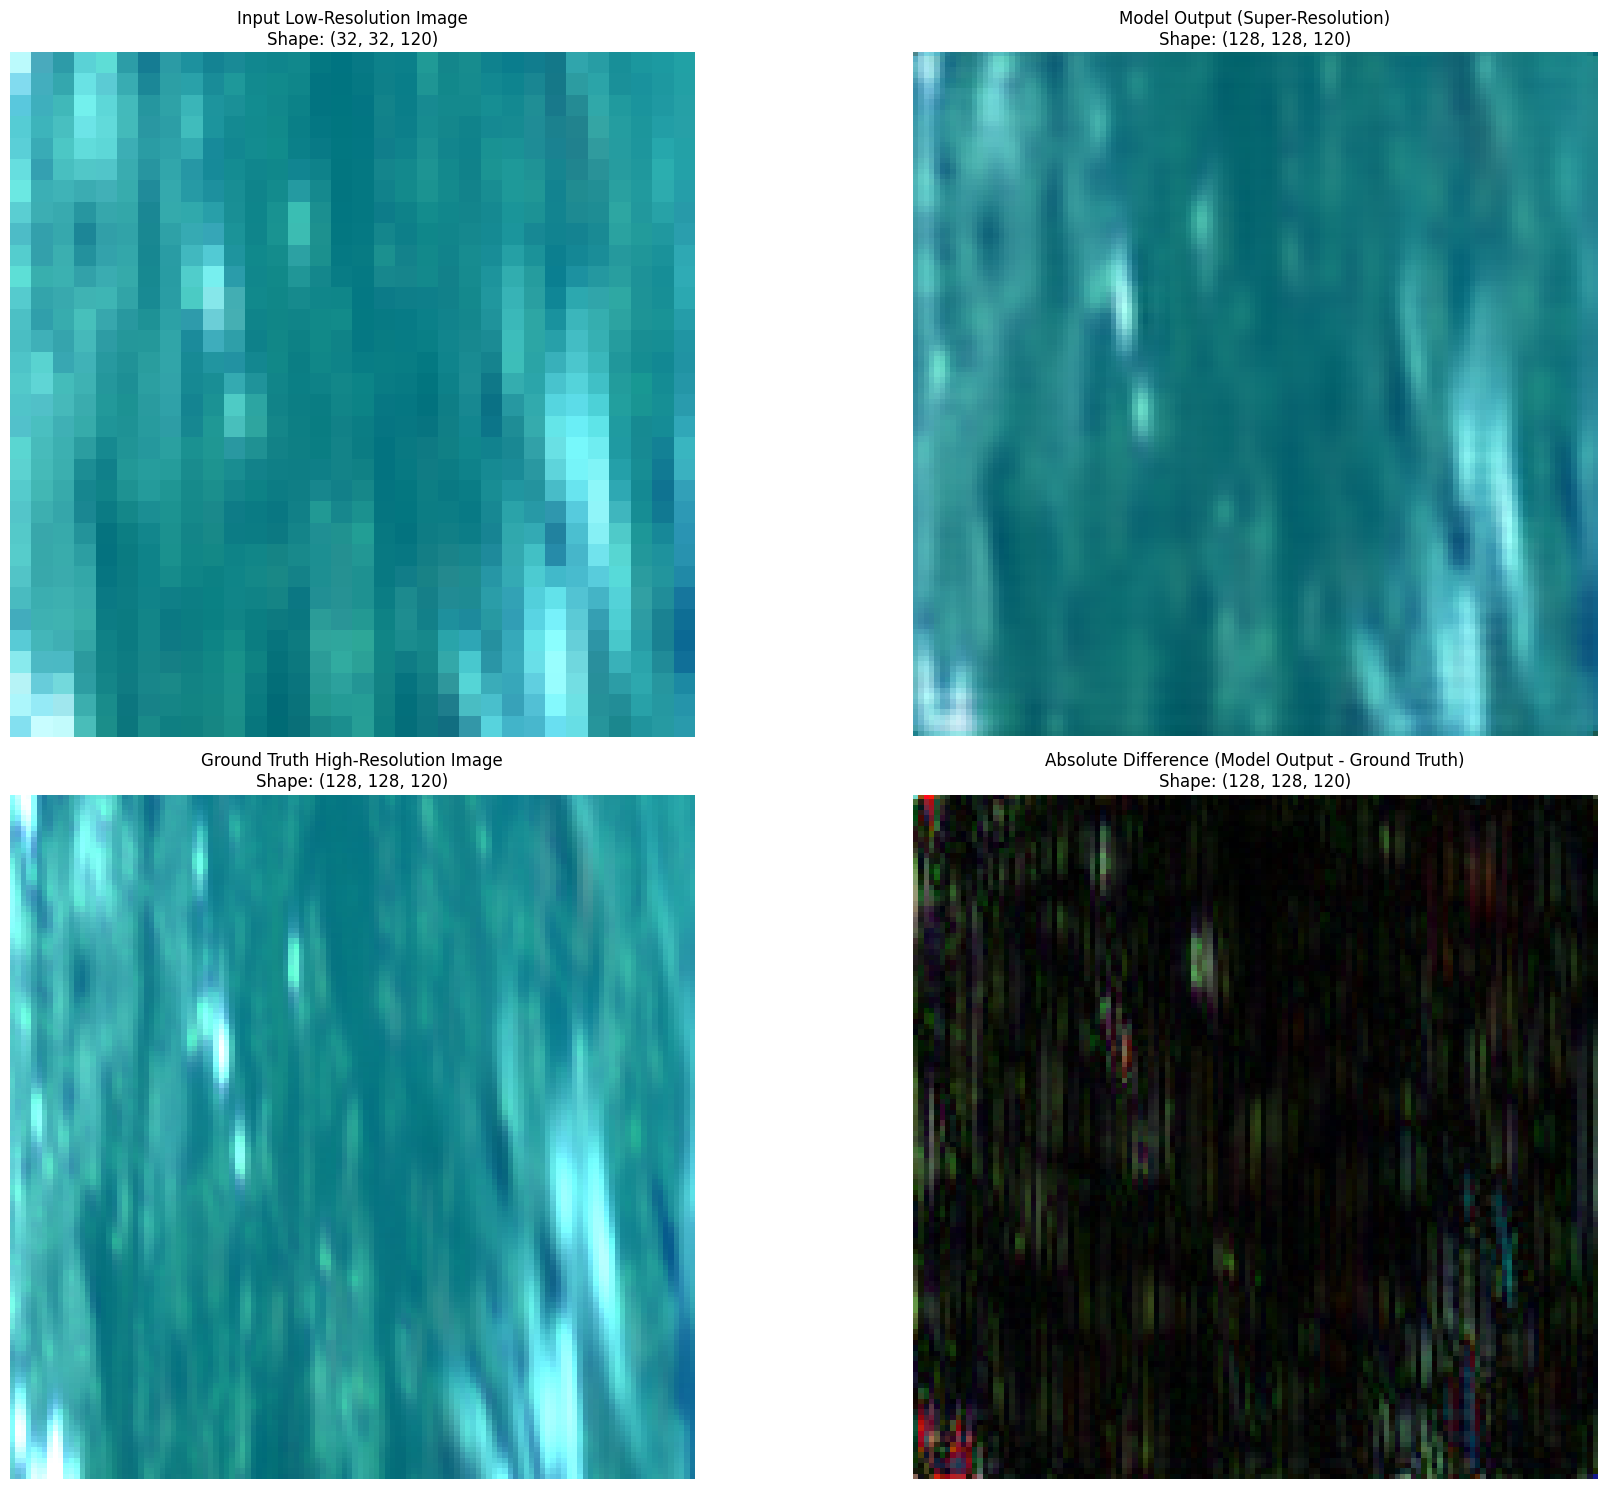


Input image stats:
Min: 0.0120
Max: 0.9989
Mean: 0.4489
Std: 0.1973

Processed image stats:
Min: -0.0221
Max: 1.1602
Mean: 0.4507
Std: 0.2003

Ground truth image stats:
Min: 0.0113
Max: 1.0000
Mean: 0.4490
Std: 0.2002

Difference image stats:
Min: 0.0000
Max: 0.3861
Mean: 0.0134
Std: 0.0162


In [68]:
hypso_npy_file = './checkpoints/hypso_hyperSigma/HyperSIGMA_35.68549924141654.npy'
hypso_gt_file = './dataset/hypso_x4/hypso_test.mat'
visualize_model_output(hypso_npy_file, hypso_gt_file, rgb_bands=[69, 46, 26])

Model output data shape: (128, 128, 128, 48)
Processed image shape: (128, 128, 48)
Ground truth image shape: (128, 128, 48)
Input image shape: (32, 32, 48)


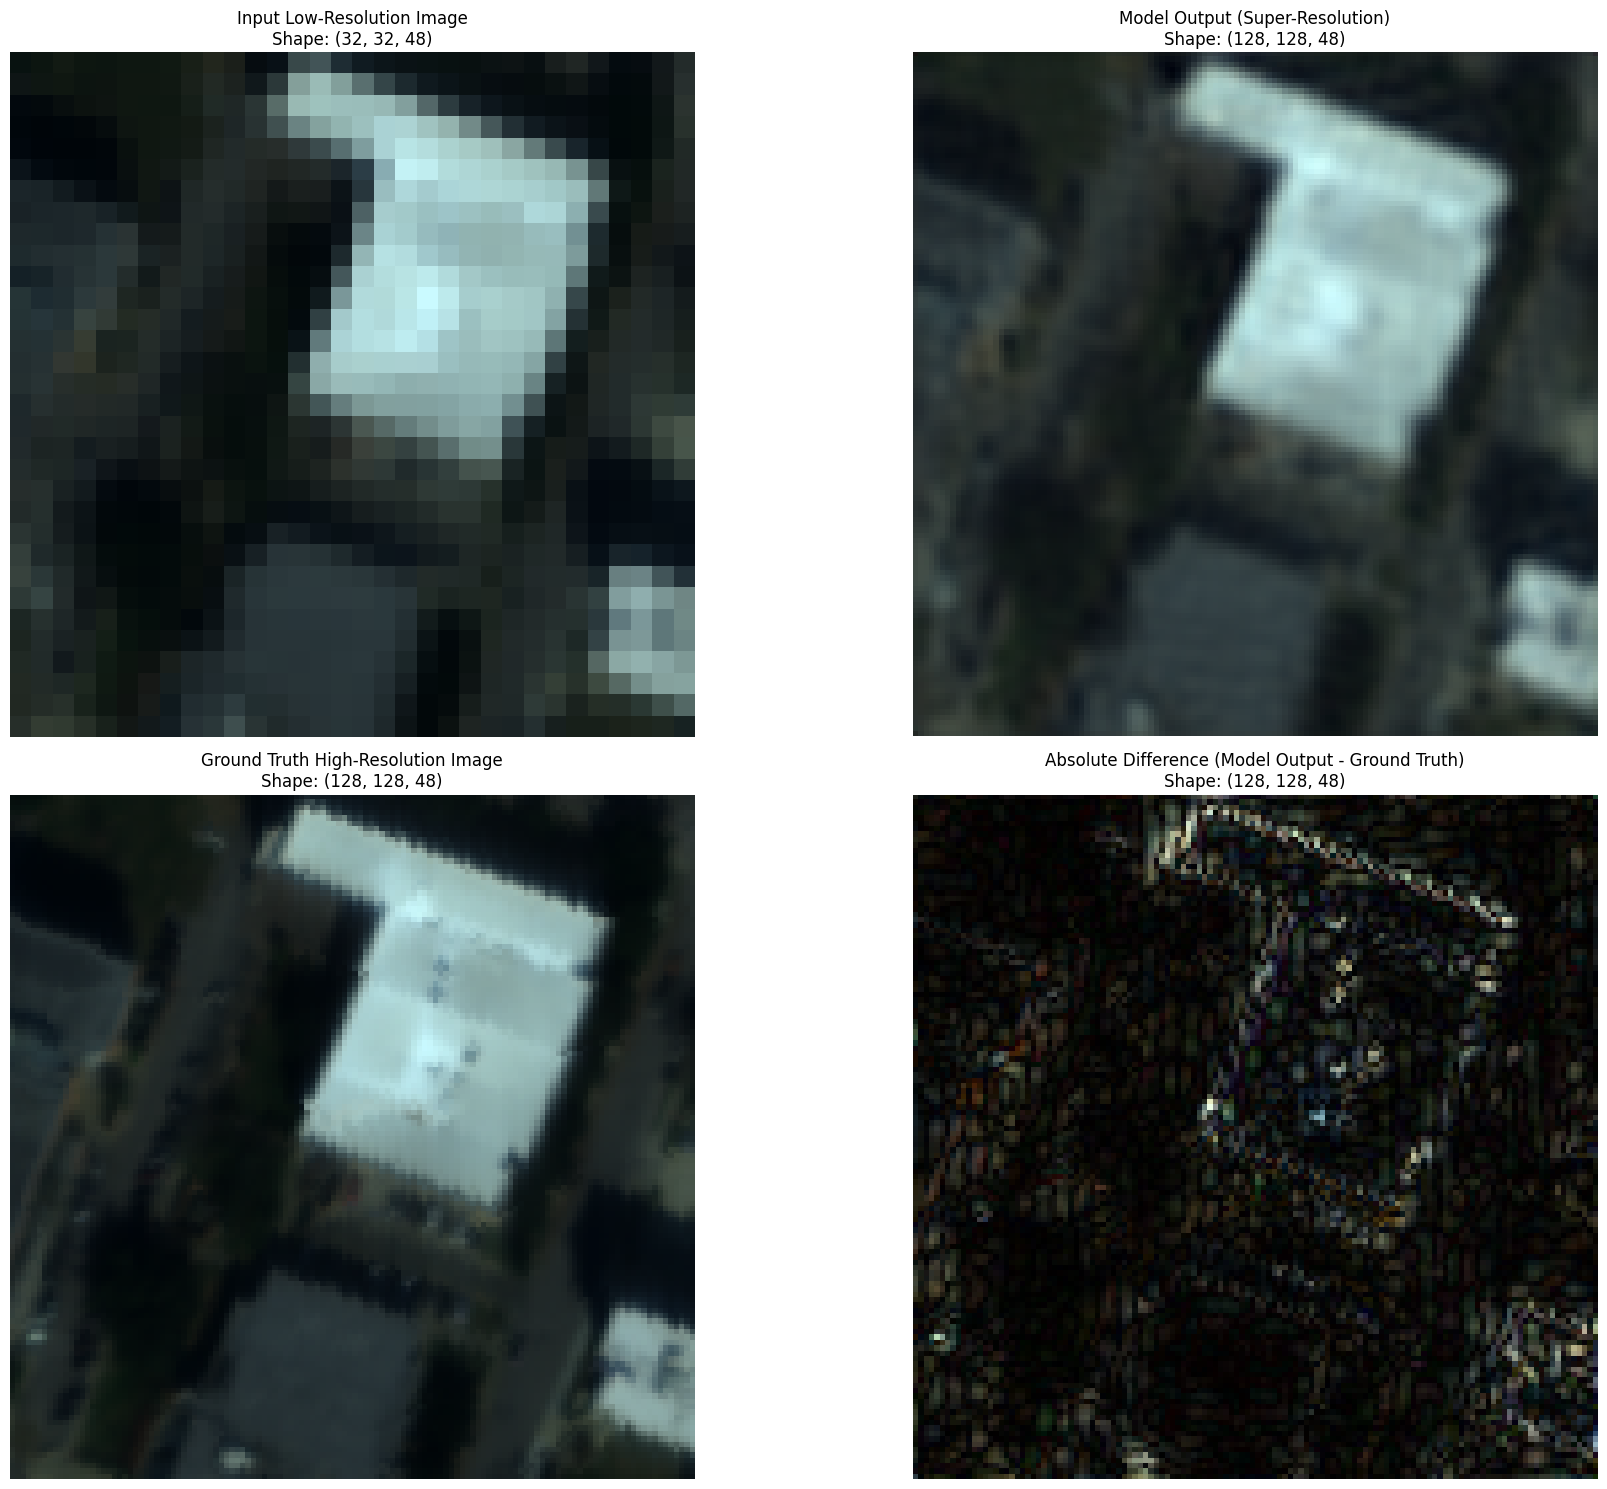


Input image stats:
Min: 0.0056
Max: 0.4492
Mean: 0.0882
Std: 0.0773

Processed image stats:
Min: -0.0226
Max: 0.4635
Mean: 0.0883
Std: 0.0799

Ground truth image stats:
Min: 0.0047
Max: 0.4737
Mean: 0.0882
Std: 0.0801

Difference image stats:
Min: 0.0000
Max: 0.1003
Mean: 0.0058
Std: 0.0070


In [69]:
houston_npy_file = './checkpoints/houston_spatSigma/SpatSIGMA_42.014431822509316.npy'
houston_gt_file = './dataset/houston_x4/houston_test.mat'
visualize_model_output(houston_npy_file, houston_gt_file, rgb_bands=[22, 14, 7])

In [48]:
def safe_resize(image, output_shape, anti_aliasing=True):
    """Safely resize an image, handling potential errors."""
    try:
        # Resize spatial dimensions only, preserve all channels
        resized = np.zeros((output_shape[0], output_shape[1], image.shape[2]), dtype=image.dtype)
        for i in range(image.shape[2]):
            resized[:,:,i] = resize(image[:,:,i], (output_shape[0], output_shape[1]), anti_aliasing=anti_aliasing)
        return resized
    except Exception as e:
        print(f"Error during resize: {e}")
        print(f"Input shape: {image.shape}, Output shape: {output_shape}")
        print(f"Input min: {np.min(image)}, max: {np.max(image)}, has NaN: {np.isnan(image).any()}")
        return np.zeros((output_shape[0], output_shape[1], image.shape[2]))  # Return a zero array if resize fails

def prepare_hyperspectral_dataset(input_file, output_dir, dataset_name, patch_size=128, test_size=128, scale_factor=4):
    # Load the data
    data = scipy.io.loadmat(input_file)
    image = data['data']  # Assuming 'data' is the key in the .mat file
    
    print(f"Original image shape: {image.shape}")
    print(f"Data type: {image.dtype}")
    print(f"Min value: {np.min(image)}, Max value: {np.max(image)}")
    
    # Transpose image to (H, W, C) format
    image = np.transpose(image, (1, 2, 0))
    
    # Check for NaN or infinite values
    if np.isnan(image).any() or np.isinf(image).any():
        print("Warning: NaN or infinite values found in the data. Replacing with mean values.")
        image = np.nan_to_num(image, nan=np.nanmean(image), posinf=np.nanmax(image), neginf=np.nanmin(image))
    
    # Ensure the data is in float format and normalized
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    image = image.astype(np.float32)
    
    # Create output directories
    train_dir = os.path.join(output_dir, f'{dataset_name}_x{scale_factor}', 'trains')
    test_dir = os.path.join(output_dir, f'{dataset_name}_x{scale_factor}')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Extract patches for training
    stride = patch_size // 2
    for i in range(0, image.shape[0] - patch_size + 1, stride):
        for j in range(0, image.shape[1] - patch_size + 1, stride):
            patch = image[i:i+patch_size, j:j+patch_size, :]
            lr_patch = safe_resize(patch, (patch_size//scale_factor, patch_size//scale_factor))
            bicubic_patch = safe_resize(lr_patch, (patch_size, patch_size))
            scipy.io.savemat(f'{train_dir}/patch_{i}_{j}.mat', 
                             {'gt': patch, 'ms': lr_patch, 'ms_bicubic': bicubic_patch})
    
    # Prepare test image
    test_start_h = max(0, min(image.shape[0] // 2 - test_size // 2, image.shape[0] - test_size))
    test_start_w = max(0, min((image.shape[1] // 2 - test_size // 2) + patch_size, image.shape[1] - test_size))
    test_image = image[test_start_h:test_start_h+test_size, test_start_w:test_start_w+test_size, :]
    
    # Ensure test_image has the correct size
    if test_image.shape[:2] != (test_size, test_size):
        test_image = safe_resize(test_image, (test_size, test_size))
    
    lr_test = safe_resize(test_image, (test_size//scale_factor, test_size//scale_factor))
    bicubic_test = safe_resize(lr_test, (test_size, test_size))
    scipy.io.savemat(f'{test_dir}/{dataset_name}_test.mat', 
                     {'gt': test_image, 'ms': lr_test, 'ms_bicubic': bicubic_test})
    
    print(f"Dataset prepared and saved in {output_dir}")
    print(f"Training patches: {len(os.listdir(train_dir))}")
    print(f"Training patch shape: {patch.shape}")
    print(f"Test LR image shape: {lr_test.shape}")
    print(f"Test Bicubic image shape: {bicubic_test.shape}")
    print(f"Test HR image shape: {test_image.shape}")

# Example usage:
prepare_hyperspectral_dataset('./dataset/hypso/vb_a_simple.mat', './dataset', 'hypso', patch_size=128, test_size=128, scale_factor=4)

Original image shape: (120, 1092, 598)
Data type: float32
Min value: 0.00927960965782404, Max value: 1.0
Dataset prepared and saved in ./dataset
Training patches: 128
Training patch shape: (128, 128, 120)
Test LR image shape: (32, 32, 120)
Test Bicubic image shape: (128, 128, 120)
Test HR image shape: (128, 128, 120)


In [49]:
!bash test_houston.sh 4 HyperSIGMA hypso ./checkpoints/hypso_hyperSigma/hypso_hyperSigma_10.pth

===>GPU: 0
===> Loading testset
test_data_dir: ./dataset/hypso_x4/hypso_test.mat
model_name: ./checkpoints/hypso_hyperSigma/hypso_hyperSigma_10.pth

------HSTestData------
HSTestData ms shape: (32, 32, 120)
HSTestData lms shape: (128, 128, 120)
HSTestData gt shape: (128, 128, 120)
HSTestData use_3Dconv: False

===> Start testing
===> Building model:HyperSIGMA
Initializing HyperSIGMA model with 120 channels
 iteration 0 of 128
 iteration 1 of 128
 iteration 2 of 128
 iteration 3 of 128
 iteration 4 of 128
 iteration 5 of 128
 iteration 6 of 128
 iteration 7 of 128
 iteration 8 of 128
 iteration 9 of 128
 iteration 10 of 128
 iteration 11 of 128
 iteration 12 of 128
 iteration 13 of 128
 iteration 14 of 128
 iteration 15 of 128
 iteration 16 of 128
 iteration 17 of 128
 iteration 18 of 128
 iteration 19 of 128
 iteration 20 of 128
 iteration 21 of 128
 iteration 22 of 128
 iteration 23 of 128
 iteration 24 of 128
 iteration 25 of 128
 iteration 26 of 128
 iteration 27 of 128
 iteration 2

In [36]:
# !bash train_houston.sh 4 1 SpatSIGMA hypso
!bash train_houston.sh 4 1 HyperSIGMA hypso

===>GPU: 0
cuda
Start seed:  3000
===> Loading datasets
train_path: ./dataset/hypso_x4/trains/
test_data_dir: ./dataset/hypso_x4/hypso_test.mat
result_path: ./results/hypso_x4/
-----------------

------HSTrainingData------
HSTrainingData image_files: ./dataset/hypso_x4/trains/patch_576_128.mat
HSTrainingData factor: 8
HSTrainingData use_3Dconv: False
Shape of 'ms' in first file: (32, 32, 120)
Shape of 'ms_bicubic' in first file: (128, 128, 120)
Shape of 'gt' in first file: (128, 128, 120)

------HSTestData------
HSTestData ms shape: (32, 32, 120)
HSTestData lms shape: (128, 128, 120)
HSTestData gt shape: (128, 128, 120)
HSTestData use_3Dconv: False

===> Building model:HyperSIGMA
Building HyperSIGMA model with original_channels: 120
Building HyperSIGMA model with args:
subcommand: train
cuda: 1
batch_size: 1
epochs: 10
n_feats: 180
n_scale: 4
use_share: True
dataset_name: hypso
model_title: HyperSIGMA
pretrain_path: /home/lofty/CODE/HyperSIGMA-fork/spat-base.pth
seed: 3000
la1: 0.3
la2